# 06 — Robustness and Marginal Analysis


In [1]:
import os, sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
project_root = os.path.abspath("..")
sys.path.append(project_root)
from config import DATA_PATH, FEE_BPS, SLIPPAGE_BPS
from Data.raw_data_loader import load_raw_crypto_csv
from Models.ou import build_spread, ou_signal_on_spread
from Models.zscore import zscore_signal_on_spread
from Models.trend import trend_signal
from Backtest.metrics import build_summary_table
sns.set_theme(style="whitegrid")


In [2]:
def sharpe_ratio(r: pd.Series) -> float:
    r = r.dropna()
    if len(r) < 60 or r.std() == 0: return np.nan
    return float(np.sqrt(365) * r.mean() / r.std())

def pair_returns(df: pd.DataFrame, pos: pd.Series, beta_window: int = 180, orientation: int = -1) -> pd.Series:
    log_b = np.log(df["BTC-USD_close"].astype(float)); log_e = np.log(df["ETH-USD_close"].astype(float))
    minp = min(beta_window, max(30, beta_window // 3))
    beta = (log_b.rolling(beta_window, min_periods=minp).cov(log_e) / log_e.rolling(beta_window, min_periods=minp).var()).replace([np.inf, -np.inf], np.nan).ffill().fillna(0.0)
    rb = df["BTC-USD_close"].astype(float).pct_change().fillna(0.0); re = df["ETH-USD_close"].astype(float).pct_change().fillna(0.0)
    p = pos.reindex(df.index).fillna(0.0); gross = p * (re - beta * rb)
    if int(orientation) == -1: gross = -gross
    return gross - p.diff().abs().fillna(0.0) * (FEE_BPS + SLIPPAGE_BPS) / 1e4


In [3]:
df = load_raw_crypto_csv(DATA_PATH).loc["2017-11-12":].copy()
mask = (df["BTC-USD_close"] > 0) & (df["ETH-USD_close"] > 0)
mask &= (df["BTC-USD_close"].pct_change().abs() < 1.0)
mask &= (df["ETH-USD_close"].pct_change().abs() < 1.0)
df = df.loc[mask].copy()
spread = build_spread(df, beta_window=180)
ou_pos = ou_signal_on_spread(spread, window=60, entry_z=1.25, exit_z=0.2, long_short=True)
z_pos = zscore_signal_on_spread(spread, window=60, entry_z=1.25, exit_z=0.3, long_short=True)
trend_pos = trend_signal(pd.DataFrame({"spread": spread}), price_column="spread", fast_window=20, slow_window=90, long_only=False, leverage_aggressive=1.0, leverage_neutral=0.0, leverage_defensive=-1.0)
ensemble_pos = (0.65 * ou_pos.reindex(df.index).fillna(0.0) + 0.25 * z_pos.reindex(df.index).fillna(0.0) + 0.10 * trend_pos.reindex(df.index).fillna(0.0)).clip(-1.0, 1.0)
ret_ou = pair_returns(df, ou_pos, beta_window=180, orientation=-1)
ret_z = pair_returns(df, z_pos, beta_window=180, orientation=-1)
ret_tr = pair_returns(df, trend_pos, beta_window=180, orientation=-1)
ret_en = pair_returns(df, ensemble_pos, beta_window=180, orientation=-1)
build_summary_table({"OU": {"returns": ret_ou, "position": ou_pos}, "Z": {"returns": ret_z, "position": z_pos}, "Trend": {"returns": ret_tr, "position": trend_pos}, "Ensemble": {"returns": ret_en, "position": ensemble_pos}}).sort_values("Sharpe", ascending=False)


,Sharpe,Sortino,CAGR,MaxDD,Calmar,AnnualReturn,AnnualVol,Observations,AnnualTurnover
Strategy,,,,,,,,,
Z,0.713472,1.002268,0.281846,-0.804195,0.350469,0.424463,0.594927,3008,9.035266
Trend,0.037052,0.051188,-0.141363,-0.963217,-0.146762,0.021900,0.591060,3008,7.797558
OU,-0.859802,-1.011821,-0.470036,-0.995903,-0.471970,-0.477746,0.555646,3008,8.045100
Ensemble,-0.980388,-1.202757,-0.200049,-0.863234,-0.231744,-0.201865,0.205903,3008,7.863032


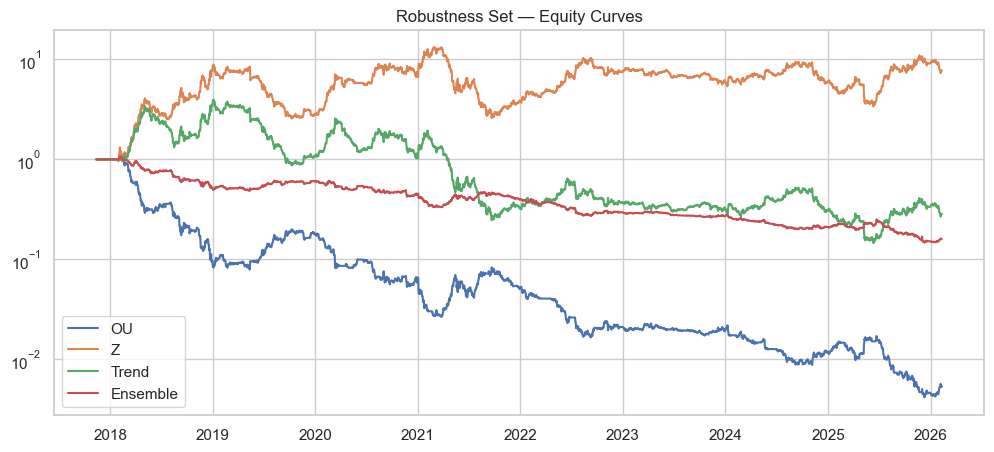

In [4]:
plt.figure(figsize=(12, 5))
for name, r in {"OU": ret_ou, "Z": ret_z, "Trend": ret_tr, "Ensemble": ret_en}.items():
    plt.plot((1 + r.fillna(0.0)).cumprod(), label=name)
plt.yscale("log"); plt.title("Robustness Set — Equity Curves"); plt.legend(); plt.show()


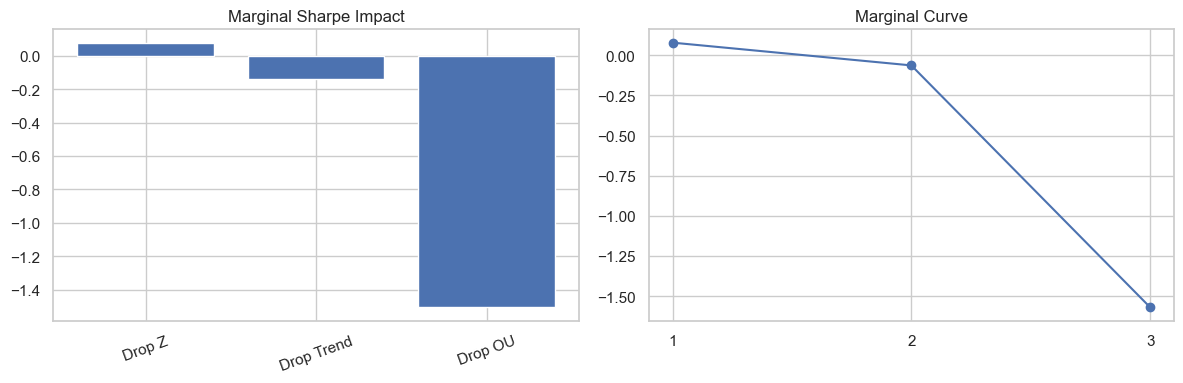

,Scenario,Sharpe,MarginalImpact,CumulativeImpact
1,Drop Z,-1.058892,0.078504,0.078504
2,Drop Trend,-0.838639,-0.141749,-0.063244
0,Drop OU,0.525987,-1.506375,-1.569619


In [5]:
base_s = sharpe_ratio(ret_en); rows = []
for name, w in {"Drop OU": (0.0, 0.7, 0.3), "Drop Z": (0.8, 0.0, 0.2), "Drop Trend": (0.7, 0.3, 0.0)}.items():
    pos = (w[0] * ou_pos.reindex(df.index).fillna(0.0) + w[1] * z_pos.reindex(df.index).fillna(0.0) + w[2] * trend_pos.reindex(df.index).fillna(0.0)).clip(-1.0, 1.0)
    s = sharpe_ratio(pair_returns(df, pos, beta_window=180, orientation=-1))
    rows.append((name, s, base_s - s))
marg = pd.DataFrame(rows, columns=["Scenario", "Sharpe", "MarginalImpact"]).sort_values("MarginalImpact", ascending=False)
marg["CumulativeImpact"] = marg["MarginalImpact"].cumsum()
fig, ax = plt.subplots(1, 2, figsize=(12, 4))
ax[0].bar(marg["Scenario"], marg["MarginalImpact"]); ax[0].set_title("Marginal Sharpe Impact"); ax[0].tick_params(axis="x", rotation=20)
ax[1].plot(range(1, len(marg)+1), marg["CumulativeImpact"], marker="o"); ax[1].set_xticks(range(1, len(marg)+1)); ax[1].set_title("Marginal Curve")
plt.tight_layout(); plt.show()
marg


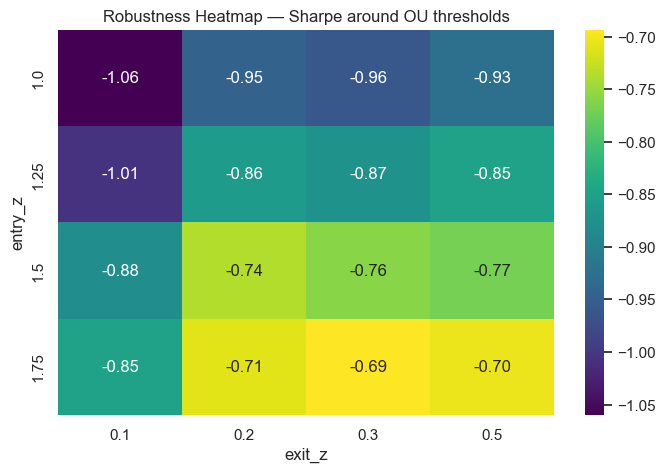

In [6]:
entry_grid = [1.0, 1.25, 1.5, 1.75]; exit_grid = [0.1, 0.2, 0.3, 0.5]
rob = pd.DataFrame(index=entry_grid, columns=exit_grid, dtype=float)
for e in entry_grid:
    for x in exit_grid:
        if x >= e: continue
        pos = ou_signal_on_spread(spread, window=60, entry_z=e, exit_z=x, long_short=True)
        rob.loc[e, x] = sharpe_ratio(pair_returns(df, pos, beta_window=180, orientation=-1))
plt.figure(figsize=(8, 5)); sns.heatmap(rob.astype(float), annot=True, fmt=".2f", cmap="viridis")
plt.title("Robustness Heatmap — Sharpe around OU thresholds")
plt.xlabel("exit_z"); plt.ylabel("entry_z"); plt.show()
